In [1]:
import re
import sklearn
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap                          # for consistent variable importance 
import xgboost as xgb                # gradient boosting machines 
import xgboost
from sklearn.metrics import brier_score_loss

from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix,precision_score,recall_score,classification_report, accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
import optuna
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_contour
import warnings

warnings.filterwarnings('ignore')

from collections import Counter
from sklearn.metrics import *
from sklearn.linear_model import *
from sklearn.model_selection import *

import os
DATA_PATH = '/kaggle/input/march-machine-learning-mania-2023/'

for filename in sorted(os.listdir(DATA_PATH)):
    print(filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Cities.csv
Conferences.csv
MConferenceTourneyGames.csv
MGameCities.csv
MMasseyOrdinals_thru_Season2023_Day128.csv
MNCAATourneyCompactResults.csv
MNCAATourneyDetailedResults.csv
MNCAATourneySeedRoundSlots.csv
MNCAATourneySeeds.csv
MNCAATourneySlots.csv
MRegularSeasonCompactResults.csv
MRegularSeasonDetailedResults.csv
MSeasons.csv
MSecondaryTourneyCompactResults.csv
MSecondaryTourneyTeams.csv
MTeamCoaches.csv
MTeamConferences.csv
MTeamSpellings.csv
MTeams.csv
SampleSubmission2023.csv
WGameCities.csv
WNCAATourneyCompactResults.csv
WNCAATourneyDetailedResults.csv
WNCAATourneySeeds.csv
WNCAATourneySlots.csv
WRegularSeasonCompactResults.csv
WRegularSeasonDetailedResults.csv
WSeasons.csv
WTeamConferences.csv
WTeamSpellings.csv
WTeams.csv


## **Goal of the Competition**

Another year, another chance to predict the upsets, call the probabilities, and put your bracketology skills to the leaderboard test. In our ninth annual March Machine Learning Mania competition, Kagglers will once again join the millions of fans who attempt to predict the outcomes of this year's college basketball tournaments. Unlike most fans, you will pick the winners and losers using a combination of rich historical data and computing power, while the ground truth unfolds on television.

## **Context**

You are provided data of historical NCAA games to forecast the outcomes of the Division 1 Men's and Women's basketball tournaments. This competition is the official 2023 edition, with points, medals, prizes, and basketball glory at stake.

We have made several updates to the competition format compared to prior editions:

    There is a change in evaluation metric from log loss to Brier scores. See the Evaluation Page for full details.
    
    We are combining the Men's and Women's tournament into one single competition, instead of running separate tracks. The competition will award full points/medals as a result.
    
    We have changed the prediction format so that you may forecast the 2023 tournaments right away, instead of having to wait to see which teams are selected for the tournament.

**I will continue to work and update this notebook. Please upvote it if you find it useful in this interesting challenge!**

## **Data Loading and Preparation**

We will start by loading the data and preparing it for analysis.

**Data Section 1 file: MNCAATourneySeeds.csv and WNCAATourneySeeds.csv**

These files identify the seeds for all teams in each NCAA® tournament, for all seasons of historical data. Thus, there are between 64-68 rows for each year, depending on whether there were any play-in games and how many there were. In recent years the structure has settled at 68 total teams, with four "play-in" games leading to the final field of 64 teams entering Round 1 on Thursday/Friday of the first week (by definition, that is DayNum=136/137 each season). We will not know the seeds of the respective tournament teams, or even exactly which 68 teams it will be, until Selection Sunday on March 12, 2023 (DayNum=132).

**Season** - the year that the tournament was played in
**Seed** - this is a 3/4-character identifier of the seed, where the first character is either W, X, Y, or Z (identifying the region the team was in) and the next two digits (either 01, 02, ..., 15, or 16) tell you the seed within the region. For play-in teams, there is a fourth character (a or b) to further distinguish the seeds, since teams that face each other in the play-in games will have seeds with the same first three characters. The "a" and "b" are assigned based on which Team ID is lower numerically. As an example of the format of the seed, the first record in the MNCAATourneySeeds file is seed W01 from 1985, which means we are looking at the #1 seed in the W region (which we can see from the "MSeasons.csv" file was the East region).
**TeamID** - this identifies the id number of the team, as specified in the MTeams.csv or WTeams.csv file

In [2]:
df_seeds = pd.concat([
    pd.read_csv(DATA_PATH + "MNCAATourneySeeds.csv"),
    pd.read_csv(DATA_PATH + "WNCAATourneySeeds.csv"),
], ignore_index=True)
    
df_seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


**Data Section 1 file: MRegularSeasonCompactResults.csv and WRegularSeasonCompactResults.csv**

These files identify the game-by-game results for many seasons of historical data, starting with the 1985 season for men (the first year the NCAA® had a 64-team men's tournament) and the 1998 season for women. For each season, the file includes all games played from DayNum 0 through 132. It is important to realize that the "Regular Season" games are simply defined to be all games played on DayNum=132 or earlier (DayNum=132 is Selection Sunday, and there are always a few conference tournament finals actually played early in the day on Selection Sunday itself). Thus a game played on or before Selection Sunday will show up here whether it was a pre-season tournament, a non-conference game, a regular conference game, a conference tournament game, or whatever.

**Season** - this is the year of the associated entry in MSeasons.csv or WSeasons.csv, namely the year in which the final tournament occurs. For example, during the 2016 season, there were regular season games played between November 2015 and March 2016, and all of those games will show up with a Season of 2016.
**DayNum** - this integer always ranges from 0 to 132, and tells you what day the game was played on. It represents an offset from the "DayZero" date in the "MSeasons.csv" or "WSeasons.csv" file. 
**WTeamID** - this identifies the id number of the team that won the game, as listed in the "MTeams.csv" or "WTeams.csv" file. No matter whether the game was won by the home team or visiting team, or if it was a neutral-site game, the "WTeamID" always identifies the winning team. Please note that in this case the "W" in "WTeamID does not refer to women's data; the "W" is for "winning". Both the men's data and women's data will identify the winning team id by this WTeamID column. The same note applies to WScore and WLoc below - these are "W" for "winning" and not for "women's".
**WScore** - this identifies the number of points scored by the winning team.
**LTeamID** - this identifies the id number of the team that lost the game.
**LScore** - this identifies the number of points scored by the losing team. Thus you can be confident that WScore will be greater than LScore for all games listed.
**WLoc** - this identifies the "location" of the winning team. If the winning team was the home team, this value will be "H". If the winning team was the visiting (or "away") team, this value will be "A". If it was played on a neutral court, then this value will be "N". Sometimes it is unclear whether the site should be considered neutral, since it is near one team's home court, or even on their court during a tournament, but for this determination we have simply used the Kenneth Massey data in its current state, where the "@" sign is either listed with the winning team, the losing team, or neither team. If you would like to investigate this factor more closely, we invite you to explore Data Section 3, which provides the city that each game was played in, irrespective of whether it was considered to be a neutral site.
**NumOT** - this indicates the number of overtime periods in the game, an integer 0 or higher.

In [3]:
df_season_results = pd.concat([
    pd.read_csv(DATA_PATH + "MRegularSeasonCompactResults.csv"),
    pd.read_csv(DATA_PATH + "WRegularSeasonCompactResults.csv"),
], ignore_index=True)

df_season_results.drop(['NumOT', 'WLoc'], axis=1, inplace=True)

In [4]:
df_season_results['ScoreGap'] = df_season_results['WScore'] - df_season_results['LScore']

Using the data provided, we will compute some features to extract additional signal in the data. 

In [5]:
num_win = df_season_results.groupby(['Season', 'WTeamID']).count()
num_win = num_win.reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={"DayNum": "NumWins", "WTeamID": "TeamID"})

In [6]:
num_loss = df_season_results.groupby(['Season', 'LTeamID']).count()
num_loss = num_loss.reset_index()[['Season', 'LTeamID', 'DayNum']].rename(columns={"DayNum": "NumLosses", "LTeamID": "TeamID"})

In [7]:
gap_win = df_season_results.groupby(['Season', 'WTeamID']).mean().reset_index()
gap_win = gap_win[['Season', 'WTeamID', 'ScoreGap']].rename(columns={"ScoreGap": "GapWins", "WTeamID": "TeamID"})

In [8]:
gap_loss = df_season_results.groupby(['Season', 'LTeamID']).mean().reset_index()
gap_loss = gap_loss[['Season', 'LTeamID', 'ScoreGap']].rename(columns={"ScoreGap": "GapLosses", "LTeamID": "TeamID"})

In [9]:
# Merge all dfs together 
df_features_season_w = df_season_results.groupby(['Season', 'WTeamID']).count().reset_index()[['Season', 'WTeamID']].rename(columns={"WTeamID": "TeamID"})
df_features_season_l = df_season_results.groupby(['Season', 'LTeamID']).count().reset_index()[['Season', 'LTeamID']].rename(columns={"LTeamID": "TeamID"})

df_features_season = pd.concat([df_features_season_w, df_features_season_l], axis=0).drop_duplicates().sort_values(['Season', 'TeamID']).reset_index(drop=True)

df_features_season = df_features_season.merge(num_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(num_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(gap_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(gap_loss, on=['Season', 'TeamID'], how='left')

# Fil NAs with 0's
df_features_season.fillna(0, inplace=True)  

In [10]:
# Create features
df_features_season['WinRatio'] = df_features_season['NumWins'] / (df_features_season['NumWins'] + df_features_season['NumLosses'])
df_features_season['GapAvg'] = (
    (df_features_season['NumWins'] * df_features_season['GapWins'] - 
    df_features_season['NumLosses'] * df_features_season['GapLosses'])
    / (df_features_season['NumWins'] + df_features_season['NumLosses'])
)

df_features_season.drop(['NumWins', 'NumLosses', 'GapWins', 'GapLosses'], axis=1, inplace=True)

**Data Section 1 file: MNCAATourneyCompactResults.csv and WNCAATourneyCompactResults.csv**

These files identify the game-by-game NCAA® tournament results for all seasons of historical data. The data is formatted exactly like the corresponding RegularSeasonCompactResults data. All men's games will show up as neutral site (so WLoc is always N) and some women's games will show up as neutral site, depending on the specifics. Note that this tournament game data also includes the play-in games for those years that had play-in games. Thus each season you will see between 63 and 67 games listed, depending on how many play-in games there were.

Because of the consistent structure of the NCAA® tournament schedule, you can generally tell what round a game was, depending on the exact DayNum. However, the men's 2021 tournament scheduling was slightly different, and the women's scheduling has varied a lot. Nevertheless, in general the men's schedule will be:

**DayNum=134 or 135 (Tue/Wed)** - play-in games to get the tournament field down to the final 64 teams

**DayNum=136 or 137 (Thu/Fri)** - Round 1, to bring the tournament field from 64 teams to 32 teams

**DayNum=138 or 139 (Sat/Sun)** - Round 2, to bring the tournament field from 32 teams to 16 teams

**DayNum=143 or 144 (Thu/Fri)** - Round 3, otherwise known as "Sweet Sixteen", to bring the tournament field from 16 teams to 8 teams

**DayNum=145 or 146 (Sat/Sun)** - Round 4, otherwise known as "Elite Eight" or "regional finals", to bring the tournament field from 8 teams to 4 teams

**DayNum=152 (Sat)** - Round 5, otherwise known as "Final Four" or "national semifinals", to bring the tournament field from 4 teams to 2 teams

**DayNum=154 (Mon)** - Round 6, otherwise known as "national final" or "national championship", to bring the tournament field from 2 teams to 1 champion team

In [11]:
df_tourney_results = pd.concat([
    pd.read_csv(DATA_PATH + "WNCAATourneyCompactResults.csv"),
    pd.read_csv(DATA_PATH + "MNCAATourneyCompactResults.csv"),
], ignore_index=True)
df_tourney_results.drop(['NumOT', 'WLoc'], axis=1, inplace=True)

In [12]:
# Training data
df = df_tourney_results.copy()
df = df[df['Season'] >= 2016].reset_index(drop=True)

df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore
0,2016,137,3107,61,3196,59
1,2016,137,3113,74,3308,52
2,2016,137,3120,68,3385,57
3,2016,137,3124,89,3225,59
4,2016,137,3177,97,3241,67


In [13]:
# SeedL is losing team and SeedW is winning team
df = pd.merge(
    df, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'WTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedW'})

In [14]:
df = pd.merge(
    df, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'LTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedL'})

def treat_seed(seed):
    return int(re.sub("[^0-9]", "", seed))

df['SeedW'] = df['SeedW'].apply(treat_seed)
df['SeedL'] = df['SeedL'].apply(treat_seed)
df.head(30)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL
0,2016,137,3107,61,3196,59,12,5
1,2016,137,3113,74,3308,52,2,15
2,2016,137,3120,68,3385,57,9,8
3,2016,137,3124,89,3225,59,1,16
4,2016,137,3177,97,3241,67,6,11
5,2016,137,3243,56,3203,51,9,8
6,2016,137,3257,87,3146,60,3,14
7,2016,137,3277,74,3125,60,4,13
8,2016,137,3280,60,3151,50,5,12
9,2016,137,3326,88,3138,69,3,14


In [15]:
df = pd.merge(
    df,
    df_features_season,
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsW',
    'NumLosses': 'NumLossesW',
    'GapWins': 'GapWinsW',
    'GapLosses': 'GapLossesW',
    'WinRatio': 'WinRatioW',
    'GapAvg': 'GapAvgW',
}).drop(columns='TeamID', axis=1)

df = pd.merge(
    df,
    df_features_season,
    how='left',
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsL',
    'NumLosses': 'NumLossesL',
    'GapWins': 'GapWinsL',
    'GapLosses': 'GapLossesL',
    'WinRatio': 'WinRatioL',
    'GapAvg': 'GapAvgL',
}).drop(columns='TeamID', axis=1)

df.head(30)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL,WinRatioW,GapAvgW,WinRatioL,GapAvgL
0,2016,137,3107,61,3196,59,12,5,0.870968,18.677419,0.733333,8.700000
1,2016,137,3113,74,3308,52,2,15,0.806452,9.258065,0.857143,8.964286
2,2016,137,3120,68,3385,57,9,8,0.612903,3.032258,0.718750,6.812500
3,2016,137,3124,89,3225,59,1,16,0.970588,24.617647,0.709677,10.612903
4,2016,137,3177,97,3241,67,6,11,0.757576,16.272727,0.843750,15.406250
5,2016,137,3243,56,3203,51,9,8,0.600000,3.933333,0.812500,9.656250
6,2016,137,3257,87,3146,60,3,14,0.781250,12.718750,0.888889,9.111111
7,2016,137,3277,74,3125,60,4,13,0.750000,11.812500,0.733333,10.266667
8,2016,137,3280,60,3151,50,5,12,0.787879,15.939394,0.774194,5.322581
9,2016,137,3326,88,3138,69,3,14,0.774194,12.258065,0.606061,1.060606


In [16]:
def add_loosing_matches(df):
    win_rename = {
        "WTeamID": "TeamIdA", 
        "WScore" : "ScoreA", 
        "LTeamID" : "TeamIdB",
        "LScore": "ScoreB",
     }
    win_rename.update({c : c[:-1] + "A" for c in df.columns if c.endswith('W')})
    win_rename.update({c : c[:-1] + "B" for c in df.columns if c.endswith('L')})
    
    lose_rename = {
        "WTeamID": "TeamIdB", 
        "WScore" : "ScoreB", 
        "LTeamID" : "TeamIdA",
        "LScore": "ScoreA",
    }
    lose_rename.update({c : c[:-1] + "B" for c in df.columns if c.endswith('W')})
    lose_rename.update({c : c[:-1] + "A" for c in df.columns if c.endswith('L')})
    
    win_df = df.copy()
    lose_df = df.copy()
    
    win_df = win_df.rename(columns=win_rename)
    lose_df = lose_df.rename(columns=lose_rename)
    
    return pd.concat([win_df, lose_df], axis=0, sort=False)

df = add_loosing_matches(df)
df.head(30)

,Season,DayNum,TeamIdA,ScoreA,TeamIdB,ScoreB,SeedA,SeedB,WinRatioA,GapAvgA,WinRatioB,GapAvgB
0,2016,137,3107,61,3196,59,12,5,0.870968,18.677419,0.733333,8.700000
1,2016,137,3113,74,3308,52,2,15,0.806452,9.258065,0.857143,8.964286
2,2016,137,3120,68,3385,57,9,8,0.612903,3.032258,0.718750,6.812500
3,2016,137,3124,89,3225,59,1,16,0.970588,24.617647,0.709677,10.612903
4,2016,137,3177,97,3241,67,6,11,0.757576,16.272727,0.843750,15.406250
5,2016,137,3243,56,3203,51,9,8,0.600000,3.933333,0.812500,9.656250
6,2016,137,3257,87,3146,60,3,14,0.781250,12.718750,0.888889,9.111111
7,2016,137,3277,74,3125,60,4,13,0.750000,11.812500,0.733333,10.266667
8,2016,137,3280,60,3151,50,5,12,0.787879,15.939394,0.774194,5.322581
9,2016,137,3326,88,3138,69,3,14,0.774194,12.258065,0.606061,1.060606


In [17]:
cols_to_diff = [
    'Seed', 'WinRatio', 'GapAvg'
]

for col in cols_to_diff:
    df[col + 'Diff'] = df[col + 'A'] - df[col + 'B']

Now we will prepare the test data and get it into the correct format.

In [18]:
df_test = pd.read_csv(DATA_PATH + "SampleSubmission2023.csv")
df_test['Season'] = df_test['ID'].apply(lambda x: int(x.split('_')[0]))
df_test['TeamIdA'] = df_test['ID'].apply(lambda x: int(x.split('_')[1]))
df_test['TeamIdB'] = df_test['ID'].apply(lambda x: int(x.split('_')[2]))

df_test.head(30)

,ID,Pred,Season,TeamIdA,TeamIdB
0,2023_1101_1102,0.5,2023,1101,1102
1,2023_1101_1103,0.5,2023,1101,1103
2,2023_1101_1104,0.5,2023,1101,1104
3,2023_1101_1105,0.5,2023,1101,1105
4,2023_1101_1106,0.5,2023,1101,1106
5,2023_1101_1107,0.5,2023,1101,1107
6,2023_1101_1108,0.5,2023,1101,1108
7,2023_1101_1110,0.5,2023,1101,1110
8,2023_1101_1111,0.5,2023,1101,1111
9,2023_1101_1112,0.5,2023,1101,1112


In [19]:
df_test = pd.merge(
    df_test,
    df_seeds,
    how='left',
    left_on=['Season', 'TeamIdA'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedA'}).fillna('W01')

df_test = pd.merge(
    df_test, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'TeamIdB'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedB'}).fillna('W01')
df_test['SeedA'] = df_test['SeedA'].apply(treat_seed)
df_test['SeedB'] = df_test['SeedB'].apply(treat_seed)
df_test.head(30)

,ID,Pred,Season,TeamIdA,TeamIdB,SeedA,SeedB
0,2023_1101_1102,0.5,2023,1101,1102,1,1
1,2023_1101_1103,0.5,2023,1101,1103,1,1
2,2023_1101_1104,0.5,2023,1101,1104,1,1
3,2023_1101_1105,0.5,2023,1101,1105,1,1
4,2023_1101_1106,0.5,2023,1101,1106,1,1
5,2023_1101_1107,0.5,2023,1101,1107,1,1
6,2023_1101_1108,0.5,2023,1101,1108,1,1
7,2023_1101_1110,0.5,2023,1101,1110,1,1
8,2023_1101_1111,0.5,2023,1101,1111,1,1
9,2023_1101_1112,0.5,2023,1101,1112,1,2


In [20]:
df_test = pd.merge(
    df_test,
    df_features_season,
    how='left',
    left_on=['Season', 'TeamIdA'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsA',
    'NumLosses': 'NumLossesA',
    'GapWins': 'GapWinsA',
    'GapLosses': 'GapLossesA',
    'WinRatio': 'WinRatioA',
    'GapAvg': 'GapAvgA',
}).drop(columns='TeamID', axis=1)

df_test = pd.merge(
    df_test,
    df_features_season,
    how='left',
    left_on=['Season', 'TeamIdB'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsB',
    'NumLosses': 'NumLossesB',
    'GapWins': 'GapWinsB',
    'GapLosses': 'GapLossesB',
    'WinRatio': 'WinRatioB',
    'GapAvg': 'GapAvgB',
}).drop(columns='TeamID', axis=1)

In [21]:
for col in cols_to_diff:
    df_test[col + 'Diff'] = df_test[col + 'A'] - df_test[col + 'B']
    
# Compute Difference in Final Score (ScoreDiff) and whether or not the team won (WinA)
df['ScoreDiff'] = df['ScoreA'] - df['ScoreB']
df['WinA'] = (df['ScoreDiff'] > 0).astype(int)

## **Exploratory Data Analysis**

ScoreDiff is normally distributed, and games have very few blowouts which adds excitement for fans. 

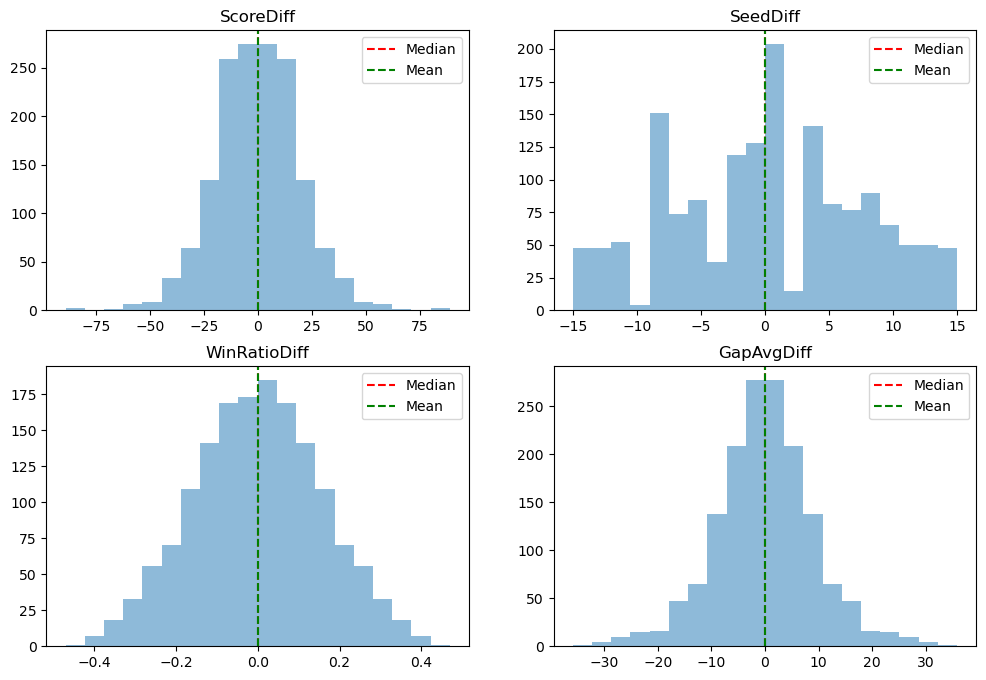

In [22]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# plot ScoreDiff
axes[0, 0].hist(df['ScoreDiff'], bins=20, alpha=0.5)
axes[0, 0].axvline(df['ScoreDiff'].median(), color='red', linestyle='--', label='Median')
axes[0, 0].axvline(df['ScoreDiff'].mean(), color='green', linestyle='--', label='Mean')
axes[0, 0].set_title('ScoreDiff')
axes[0, 0].legend()

# plot SeedDiff
axes[0, 1].hist(df['SeedDiff'], bins=20, alpha=0.5)
axes[0, 1].axvline(df['SeedDiff'].median(), color='red', linestyle='--', label='Median')
axes[0, 1].axvline(df['SeedDiff'].mean(), color='green', linestyle='--', label='Mean')
axes[0, 1].set_title('SeedDiff')
axes[0, 1].legend()

# plot WinRatioDiff
axes[1, 0].hist(df['WinRatioDiff'], bins=20, alpha=0.5)
axes[1, 0].axvline(df['WinRatioDiff'].median(), color='red', linestyle='--', label='Median')
axes[1, 0].axvline(df['WinRatioDiff'].mean(), color='green', linestyle='--', label='Mean')
axes[1, 0].set_title('WinRatioDiff')
axes[1, 0].legend()

# plot GapAvgDiff
axes[1, 1].hist(df['GapAvgDiff'], bins=20, alpha=0.5)
axes[1, 1].axvline(df['GapAvgDiff'].median(), color='red', linestyle='--', label='Median')
axes[1, 1].axvline(df['GapAvgDiff'].mean(), color='green', linestyle='--', label='Mean')
axes[1, 1].set_title('GapAvgDiff')
axes[1, 1].legend()

plt.show()

In [23]:
# Split data in X and y
X = df[["SeedA", "SeedB", 'WinRatioA', 'GapAvgA', 'WinRatioB', 'GapAvgB', 'SeedDiff', 'WinRatioDiff', 'GapAvgDiff']]
y = df[['WinA']]

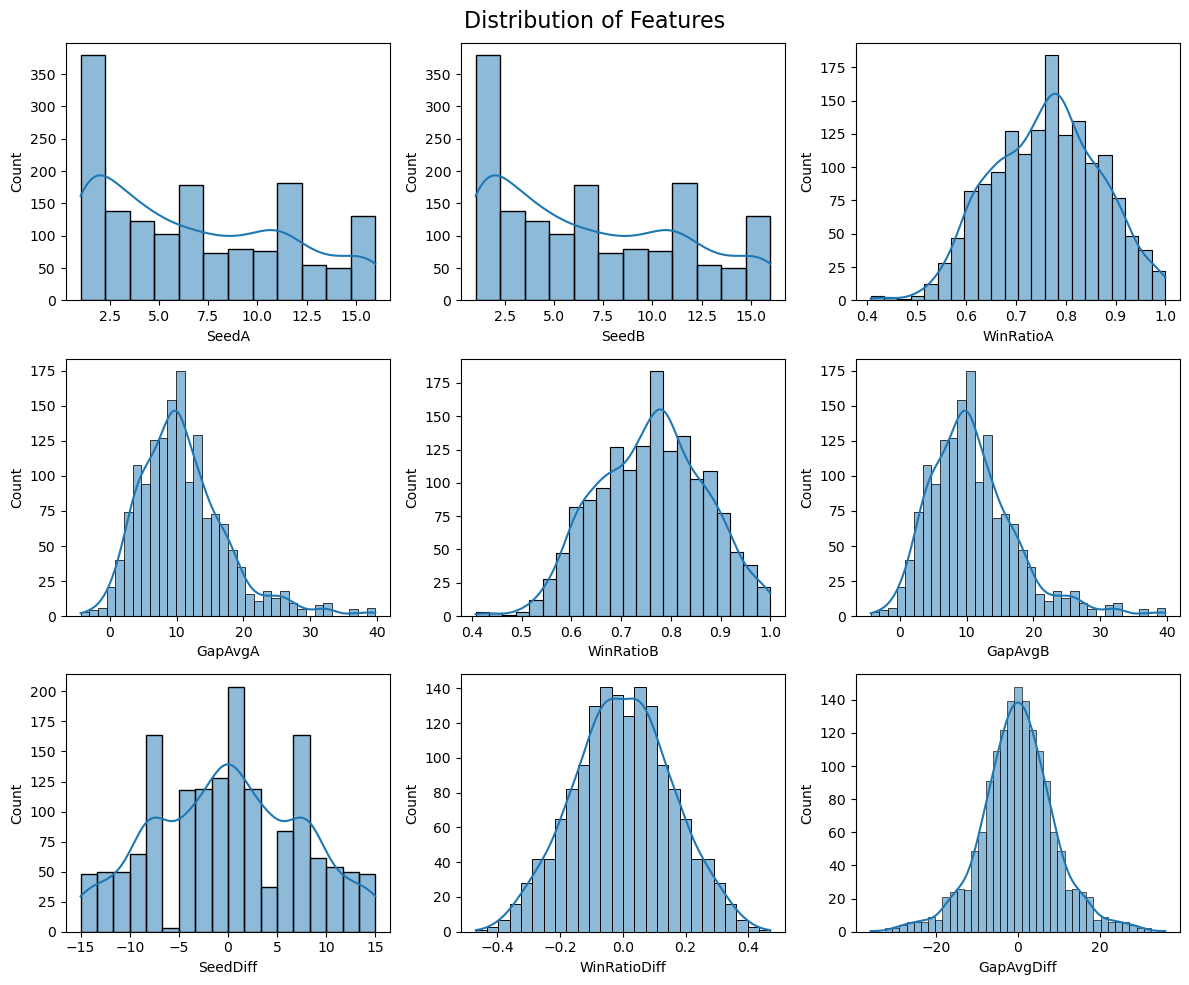

In [24]:
# create a figure with subplots for each feature
fig, axs = plt.subplots(3,3, figsize=(12, 10))

# plot the distribution of each feature
for i, col in enumerate(X.columns):
    sns.histplot(data=X, x=col, ax=axs[i//3, i%3], kde=True)
    
# add a title to the figure
fig.suptitle('Distribution of Features', fontsize=16)

# Adjust the layout of the subplots
fig.tight_layout()

# display the plot
plt.show()

In [25]:
from sklearn.preprocessing import StandardScaler

# drop columns that we don't want to scale
X = df.drop(columns=['Season', 'DayNum', 'TeamIdA', 'ScoreA', 'TeamIdB', 'ScoreB', 'WinA', 'ScoreDiff'])

# create the scaler object
scaler = StandardScaler()

# fit the scaler object to the data and transform the data
X = scaler.fit_transform(X)

# assign y values
y = df['WinA']

In [26]:
X.shape

(1566, 9)

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, plot_roc_curve

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Define brier score loss which we will use as the loss function. The neural network will minimize this function.

In [28]:
def brier_score_loss(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    return tf.reduce_mean(tf.math.squared_difference(y_true, y_pred))

## **Deep Learning**

Deep learning is a type of machine learning that is used to teach artificial neural networks how to learn from vast amounts of data. These neural networks are designed to mimic the structure of the human brain, and they are composed of layers of interconnected nodes called neurons that work in concert to process and analyze information.

In the process of deep learning, the neural network is fed large amounts of data and then adjusts its parameters through a process called backpropagation to minimize the difference between its predicted output and the actual output. This allows the neural network to recognize patterns and make accurate predictions.

Deep learning has many practical applications, such as image and speech recognition, natural language processing, and self-driving cars. It has revolutionized the field of artificial intelligence and has contributed to significant advancements in research and development.

The first neural network architecture that takes an input of shape (9,) and consists of multiple hidden layers with dropout regularization and batch normalization. Specifically, the neural network has three hidden layers, each with a dense layer, a batch normalization layer, and a dropout layer. The number of neurons in the dense layers are 128, 64, and 32 respectively. The dropout rate for each dropout layer is set to 0.3. The output layer has a single neuron with a sigmoid activation function. The model is compiled with the Adam optimizer and a custom loss function called "brier_score_loss".

Overall, this architecture has a total of 51,105 trainable parameters, which is relatively small. The use of batch normalization and dropout regularization may help prevent overfitting and improve the generalization performance of the model. The activation function and optimizer are also standard choices commonly used in neural networks

In [29]:
import tensorflow as tf

# Define the input shape
input_shape = (9,)

# Define the model architecture
# Create a neural network with dropout and multiple hidden layers
inputs = tf.keras.layers.Input(shape=input_shape)
x = tf.keras.layers.Dense(128, activation='relu')(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Create the model
model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

# Compile the model with the custom loss function
model.compile(optimizer='adam', loss=brier_score_loss)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 9)]               0         
                                                                 
 dense (Dense)               (None, 128)               1280      
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                             

In [30]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)

Epoch 1/100
40/40 [==============================] - 2s 9ms/step - loss: 0.2327 - val_loss: 0.2057
Epoch 2/100
40/40 [==============================] - 0s 4ms/step - loss: 0.2065 - val_loss: 0.2020
Epoch 3/100
40/40 [==============================] - 0s 3ms/step - loss: 0.1949 - val_loss: 0.1971
Epoch 4/100
40/40 [==============================] - 0s 4ms/step - loss: 0.1916 - val_loss: 0.1916
Epoch 5/100
40/40 [==============================] - 0s 3ms/step - loss: 0.1951 - val_loss: 0.1879
Epoch 6/100
40/40 [==============================] - 0s 3ms/step - loss: 0.1950 - val_loss: 0.1872
Epoch 7/100
40/40 [==============================] - 0s 4ms/step - loss: 0.1895 - val_loss: 0.1862
Epoch 8/100
40/40 [==============================] - 0s 4ms/step - loss: 0.1911 - val_loss: 0.1857
Epoch 9/100
40/40 [==============================] - 0s 4ms/step - loss: 0.1836 - val_loss: 0.1854
Epoch 10/100
40/40 [==============================] - 0s 4ms/step - loss: 0.1830 - val_loss: 0.1851
Epoch 11/

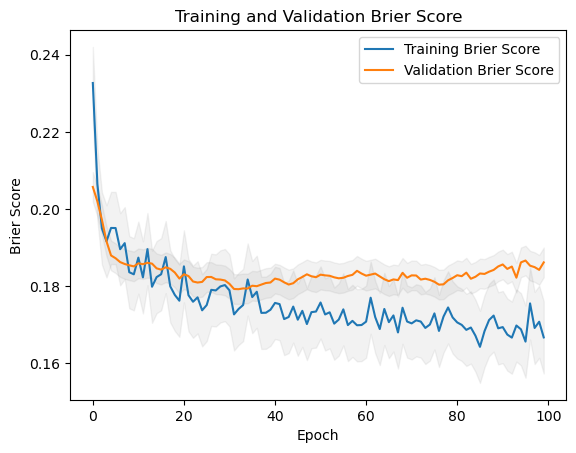

In [31]:
# Plot the loss
plt.plot(history.history['loss'], label='Training Brier Score')
plt.plot(history.history['val_loss'], label='Validation Brier Score')
loss_std = np.std(history.history['loss'])
val_loss_std = np.std(history.history['val_loss'])

plt.fill_between(range(len(history.history['loss'])), 
                 history.history['loss'] - loss_std, 
                 history.history['loss'] + loss_std, 
                 alpha=0.1, color='gray')
plt.fill_between(range(len(history.history['val_loss'])), 
                 history.history['val_loss'] - val_loss_std, 
                 history.history['val_loss'] + val_loss_std, 
                 alpha=0.1, color='gray')
plt.title('Training and Validation Brier Score')
plt.xlabel('Epoch')
plt.ylabel('Brier Score')
plt.legend()
plt.show()

The second neural network architecture with an input shape of (9,) using the TensorFlow Keras API. The model consists of three fully connected hidden layers with 256, 128, and 64 neurons, respectively. Each hidden layer is followed by a batch normalization layer and a dropout layer. The dropout rates for the first and second dropout layers are 0.5, while the third dropout layer has a dropout rate of 0.3. Finally, the output layer is a single neuron with a sigmoid activation function.

Overall, this neural network has a total of 75,009 trainable parameters, which is larger than the previously described architecture. The use of dropout and batch normalization layers may help to reduce overfitting, while the choice of the ReLU activation function is a commonly used non-linear function in neural networks. The model is compiled with the Adam optimizer and a custom loss function called "brier_score_loss", meaning model is intended for binary classification tasks where the output of the model is interpreted as the probability of belonging to the positive class.

In [32]:
# Define the input shape
input_shape = (9,)

# Define the model architecture
inputs = tf.keras.layers.Input(shape=input_shape)
x = tf.keras.layers.Dense(256, activation='relu')(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Create the model
model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

# Compile the model with the custom loss function
model.compile(optimizer='adam', loss=brier_score_loss)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 9)]               0         
                                                                 
 dense_4 (Dense)             (None, 256)               2560      
                                                                 
 batch_normalization_3 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_4 (Batc  (None, 128)              512       
 hNormalization)                                           

In [33]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)

Epoch 1/100
40/40 [==============================] - 2s 9ms/step - loss: 0.2475 - val_loss: 0.1917
Epoch 2/100
40/40 [==============================] - 0s 5ms/step - loss: 0.2158 - val_loss: 0.1956
Epoch 3/100
40/40 [==============================] - 0s 5ms/step - loss: 0.2153 - val_loss: 0.1934
Epoch 4/100
40/40 [==============================] - 0s 5ms/step - loss: 0.2075 - val_loss: 0.1928
Epoch 5/100
40/40 [==============================] - 0s 4ms/step - loss: 0.1991 - val_loss: 0.1998
Epoch 6/100
40/40 [==============================] - 0s 4ms/step - loss: 0.1995 - val_loss: 0.2019
Epoch 7/100
40/40 [==============================] - 0s 4ms/step - loss: 0.1908 - val_loss: 0.1956
Epoch 8/100
40/40 [==============================] - 0s 4ms/step - loss: 0.2024 - val_loss: 0.1910
Epoch 9/100
40/40 [==============================] - 0s 4ms/step - loss: 0.1938 - val_loss: 0.1907
Epoch 10/100
40/40 [==============================] - 0s 4ms/step - loss: 0.1877 - val_loss: 0.1886
Epoch 11/

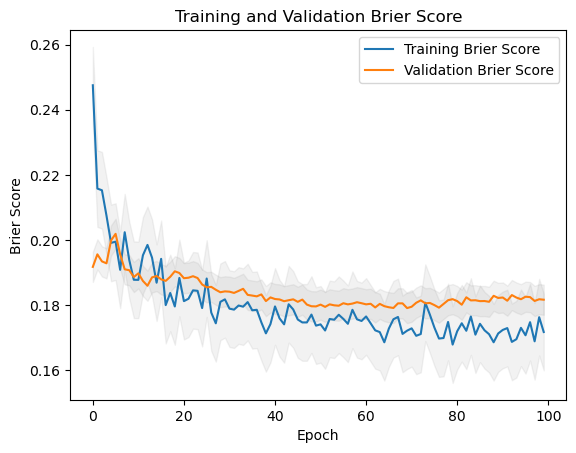

In [34]:
# Plot the loss
plt.plot(history.history['loss'], label='Training Brier Score')
plt.plot(history.history['val_loss'], label='Validation Brier Score')
loss_std = np.std(history.history['loss'])
val_loss_std = np.std(history.history['val_loss'])

plt.fill_between(range(len(history.history['loss'])), 
                 history.history['loss'] - loss_std, 
                 history.history['loss'] + loss_std, 
                 alpha=0.1, color='gray')
plt.fill_between(range(len(history.history['val_loss'])), 
                 history.history['val_loss'] - val_loss_std, 
                 history.history['val_loss'] + val_loss_std, 
                 alpha=0.1, color='gray')
plt.title('Training and Validation Brier Score')
plt.xlabel('Epoch')
plt.ylabel('Brier Score')
plt.legend()
plt.show()

The third neural network architecture consists of three fully connected hidden layers with 256, 128, and 64 neurons, respectively. Each hidden layer is followed by a batch normalization layer to normalize the output of the previous layer and a dropout layer to prevent overfitting. The dropout rates for the first and second dropout layers are 0.5, while the third dropout layer has a dropout rate of 0.3. The output layer is a single neuron with a sigmoid activation function, which is used for binary classification tasks.

The model has a total of 75,009 trainable parameters, which is larger than the previously described architecture. The use of dropout and batch normalization layers may help to reduce overfitting, while the choice of the ReLU activation function is a commonly used non-linear function in neural networks.

In [35]:
import tensorflow as tf

# Define the input shape
input_shape = (9, 1)

# Define the model architecture
inputs = tf.keras.layers.Input(shape=input_shape)
x = tf.keras.layers.Conv1D(64, 3, activation='relu')(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Conv1D(32, 3, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Create the model
model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

# Compile the model with the custom loss function
model.compile(optimizer='adam', loss=brier_score_loss)

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 9, 1)]            0         
                                                                 
 conv1d (Conv1D)             (None, 7, 64)             256       
                                                                 
 batch_normalization_6 (Batc  (None, 7, 64)            256       
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 7, 64)             0         
                                                                 
 conv1d_1 (Conv1D)           (None, 5, 32)             6176      
                                                                 
 batch_normalization_7 (Batc  (None, 5, 32)            128       
 hNormalization)                                           

In [36]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)

Epoch 1/100
40/40 [==============================] - 2s 10ms/step - loss: 0.2576 - val_loss: 0.2119
Epoch 2/100
40/40 [==============================] - 0s 5ms/step - loss: 0.2159 - val_loss: 0.2114
Epoch 3/100
40/40 [==============================] - 0s 5ms/step - loss: 0.2087 - val_loss: 0.2130
Epoch 4/100
40/40 [==============================] - 0s 5ms/step - loss: 0.2071 - val_loss: 0.1996
Epoch 5/100
40/40 [==============================] - 0s 5ms/step - loss: 0.2045 - val_loss: 0.2003
Epoch 6/100
40/40 [==============================] - 0s 5ms/step - loss: 0.2090 - val_loss: 0.1955
Epoch 7/100
40/40 [==============================] - 0s 5ms/step - loss: 0.2082 - val_loss: 0.1932
Epoch 8/100
40/40 [==============================] - 0s 5ms/step - loss: 0.2062 - val_loss: 0.1936
Epoch 9/100
40/40 [==============================] - 0s 5ms/step - loss: 0.1995 - val_loss: 0.1936
Epoch 10/100
40/40 [==============================] - 0s 5ms/step - loss: 0.1928 - val_loss: 0.1877
Epoch 11

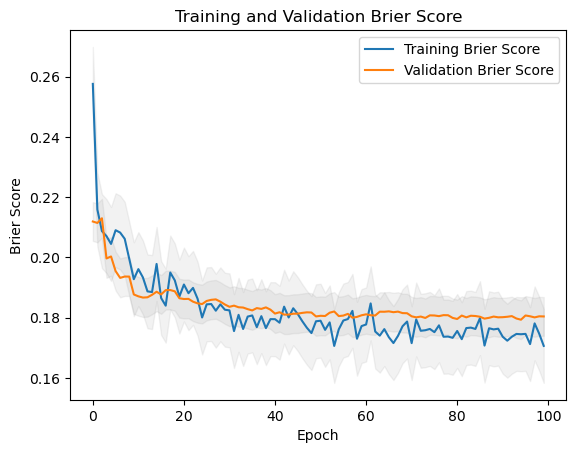

In [37]:
# Plot the loss
plt.plot(history.history['loss'], label='Training Brier Score')
plt.plot(history.history['val_loss'], label='Validation Brier Score')
loss_std = np.std(history.history['loss'])
val_loss_std = np.std(history.history['val_loss'])

plt.fill_between(range(len(history.history['loss'])), 
                 history.history['loss'] - loss_std, 
                 history.history['loss'] + loss_std, 
                 alpha=0.1, color='gray')
plt.fill_between(range(len(history.history['val_loss'])), 
                 history.history['val_loss'] - val_loss_std, 
                 history.history['val_loss'] + val_loss_std, 
                 alpha=0.1, color='gray')
plt.title('Training and Validation Brier Score')
plt.xlabel('Epoch')
plt.ylabel('Brier Score')
plt.legend()
plt.show()

## **Neural Network Hyperparameter Tuning Bayesian Optimization**

We will now implement a Bayesian hyperparameter optimization search for a neural network model. The model architecture consists of three densely-connected layers with batch normalization and dropout regularization. The hyperparameters being optimized include the number of units in each layer, the learning rate of the optimizer, and the dropout rate of each dropout layer.

The code also defines a TensorBoard callback for monitoring the model training progress and uses early stopping to prevent overfitting. Finally, it prints the best hyperparameters found by the hyperparameter search.

In [38]:
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import BayesianOptimization
from tensorflow.keras.callbacks import TensorBoard

# Define the input shape
input_shape = (9,)

# Define the model architecture
def build_model(hp):
    inputs = keras.Input(shape=input_shape)
    x = layers.Dense(hp.Int('units_1', min_value=32, max_value=512, step=32), activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1))(x)
    x = layers.Dense(hp.Int('units_2', min_value=32, max_value=256, step=32), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1))(x)
    x = layers.Dense(hp.Int('units_3', min_value=16, max_value=128, step=16), activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(hp.Float('dropout_3', min_value=0.0, max_value=0.5, step=0.1))(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    # Create the model
    model = keras.Model(inputs=inputs, outputs=outputs)

    # Compile the model with the brier_score_loss and Adam optimizer
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss=brier_score_loss,
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])
    return model

# Define the hyperparameter search space
tuner = BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=50,
    directory='my_dir',
    project_name='marchmadness_project')

# Define TensorBoard callback
tensorboard_callback = TensorBoard(log_dir='logs')

# Train the model with the Keras tuner
tuner.search(X_train, y_train,
             epochs=100,
             validation_data=(X_test, y_test),
             callbacks=[tf.keras.callbacks.EarlyStopping(patience=3), tensorboard_callback])

# Print the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"The optimal number of units in the first densely-connected layer is {best_hps.get('units_1')}")
print(f"The optimal number of units in the second densely-connected layer is {best_hps.get('units_2')}")
print(f"The optimal number of units in the third densely-connected layer is {best_hps.get('units_3')}")
print(f"The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}")
print(f"The optimal dropout rate for the first dropout layer is {best_hps.get('dropout_1')}")
print(f"The optimal dropout rate for the second dropout layer is {best_hps.get('dropout_2')}")
print(f"The optimal dropout rate for the third dropout layer is {best_hps.get('dropout_3')}")

Trial 50 Complete [00h 00m 05s]
val_loss: 0.17747066915035248

Best val_loss So Far: 0.17674271762371063
Total elapsed time: 00h 07m 47s
The optimal number of units in the first densely-connected layer is 32
The optimal number of units in the second densely-connected layer is 32
The optimal number of units in the third densely-connected layer is 16
The optimal learning rate for the optimizer is 0.01
The optimal dropout rate for the first dropout layer is 0.0
The optimal dropout rate for the second dropout layer is 0.0
The optimal dropout rate for the third dropout layer is 0.0


After running the code, TensorBoard logs can be visualized using the following command. This will open a web interface where you can view the loss and other metrics for each hyperparameter.

In [39]:
%load_ext tensorboard
%tensorboard --logdir logs

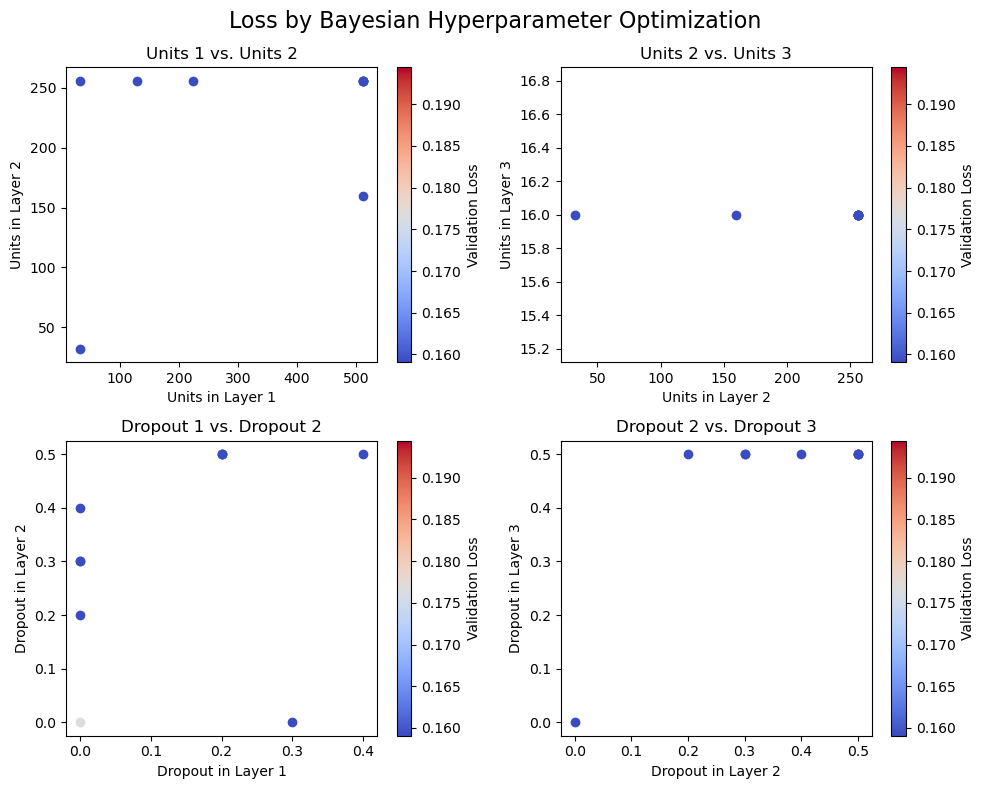

In [40]:
# Retrieve the best trials
best_trials = tuner.oracle.get_best_trials(num_trials=10)

# Create a figure with two rows and two columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Add main title
fig.suptitle("Loss by Bayesian Hyperparameter Optimization", fontsize=16)

# Plot the first graph
for trial in best_trials:
    hp = trial.hyperparameters.values
    val_loss = trial.metrics.get_best_value("val_loss")
    axes[0, 0].scatter(hp["units_1"], hp["units_2"], c=val_loss, cmap="coolwarm")
axes[0, 0].set_xlabel("Units in Layer 1")
axes[0, 0].set_ylabel("Units in Layer 2")
axes[0, 0].set_title("Units 1 vs. Units 2")

# Plot the second graph
for trial in best_trials:
    hp = trial.hyperparameters.values
    val_loss = trial.metrics.get_best_value("val_loss")
    axes[0, 1].scatter(hp["units_2"], hp["units_3"], c=val_loss, cmap="coolwarm")
axes[0, 1].set_xlabel("Units in Layer 2")
axes[0, 1].set_ylabel("Units in Layer 3")
axes[0, 1].set_title("Units 2 vs. Units 3")

# Plot the third graph
for trial in best_trials:
    hp = trial.hyperparameters.values
    val_loss = trial.metrics.get_best_value("val_loss")
    axes[1, 0].scatter(hp["dropout_1"], hp["dropout_2"], c=val_loss, cmap="coolwarm")
axes[1, 0].set_xlabel("Dropout in Layer 1")
axes[1, 0].set_ylabel("Dropout in Layer 2")
axes[1, 0].set_title("Dropout 1 vs. Dropout 2")

# Plot the fourth graph
for trial in best_trials:
    hp = trial.hyperparameters.values
    val_loss = trial.metrics.get_best_value("val_loss")
    axes[1, 1].scatter(hp["dropout_2"], hp["dropout_3"], c=val_loss, cmap="coolwarm")
axes[1, 1].set_xlabel("Dropout in Layer 2")
axes[1, 1].set_ylabel("Dropout in Layer 3")
axes[1, 1].set_title("Dropout 2 vs. Dropout 3")

# Add a colorbar to each graph
for ax in axes.flat:
    im = ax.collections[0]
    fig.colorbar(im, ax=ax, label="Validation Loss")

# Adjust the spacing between the graphs
fig.tight_layout()

# Display the figure
plt.show()

**Use best hyperparameters identified above.**

* The optimal number of units in the first densely-connected layer is **416**
* The optimal number of units in the second densely-connected layer is **192**
* The optimal number of units in the third densely-connected layer is **64**
* The optimal learning rate for the optimizer is **0.01**
* The optimal dropout rate for the first dropout layer is **0.0**
* The optimal dropout rate for the second dropout layer is **0.2**
* The optimal dropout rate for the third dropout layer is **0.5**

In [41]:
# Define the input shape
input_shape = (9,)

# Define the model architecture using best hyperparameters
inputs = keras.Input(shape=input_shape)
x = layers.Dense(416, activation='relu')(inputs)
x = layers.BatchNormalization()(x)
#x = layers.Dropout(0.5)(x)
x = layers.Dense(192, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64)(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

# Create the model
model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

# Compile the model with the brier_score_loss and Adam optimizer
model.compile(optimizer='adam', loss=brier_score_loss, metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 9)]               0         
                                                                 
 dense_4 (Dense)             (None, 416)               4160      
                                                                 
 batch_normalization_3 (Batc  (None, 416)              1664      
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 192)               80064     
                                                                 
 batch_normalization_4 (Batc  (None, 192)              768       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 192)               0   

In [42]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100)

Epoch 1/100
40/40 [==============================] - 3s 18ms/step - loss: 0.2314 - accuracy: 0.6853 - precision_1: 0.6847 - recall_1: 0.6998 - auc_1: 0.7671 - val_loss: 0.1877 - val_accuracy: 0.7102 - val_precision_1: 0.7007 - val_recall_1: 0.6867 - val_auc_1: 0.7980
Epoch 2/100
40/40 [==============================] - 0s 6ms/step - loss: 0.2110 - accuracy: 0.7093 - precision_1: 0.7138 - recall_1: 0.7093 - auc_1: 0.7777 - val_loss: 0.1851 - val_accuracy: 0.7038 - val_precision_1: 0.6707 - val_recall_1: 0.7467 - val_auc_1: 0.7988
Epoch 3/100
40/40 [==============================] - 0s 7ms/step - loss: 0.2045 - accuracy: 0.7141 - precision_1: 0.7119 - recall_1: 0.7299 - auc_1: 0.7862 - val_loss: 0.1859 - val_accuracy: 0.6943 - val_precision_1: 0.6467 - val_recall_1: 0.7933 - val_auc_1: 0.7981
Epoch 4/100
40/40 [==============================] - 0s 6ms/step - loss: 0.2059 - accuracy: 0.7173 - precision_1: 0.7218 - recall_1: 0.7172 - auc_1: 0.7859 - val_loss: 0.1866 - val_accuracy: 0.6847 

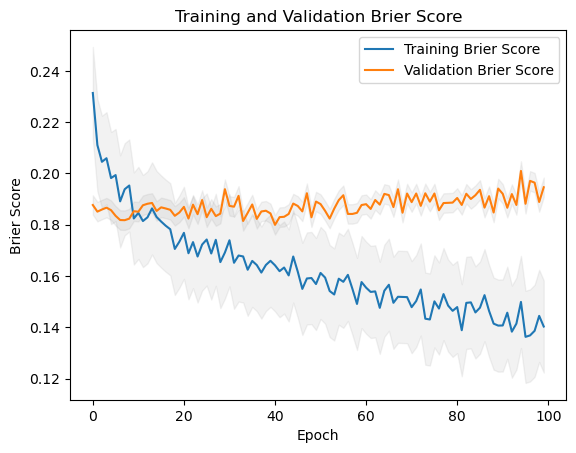

In [43]:
# Plot the loss
plt.plot(history.history['loss'], label='Training Brier Score')
plt.plot(history.history['val_loss'], label='Validation Brier Score')
loss_std = np.std(history.history['loss'])
val_loss_std = np.std(history.history['val_loss'])

plt.fill_between(range(len(history.history['loss'])), 
                 history.history['loss'] - loss_std, 
                 history.history['loss'] + loss_std, 
                 alpha=0.1, color='gray')
plt.fill_between(range(len(history.history['val_loss'])), 
                 history.history['val_loss'] - val_loss_std, 
                 history.history['val_loss'] + val_loss_std, 
                 alpha=0.1, color='gray')
plt.title('Training and Validation Brier Score')
plt.xlabel('Epoch')
plt.ylabel('Brier Score')
plt.legend()
plt.show()

## **Make Predictions**

In [44]:
features = [
    "SeedA", "SeedB", 'WinRatioA', 'GapAvgA', 'WinRatioB', 'GapAvgB', 'SeedDiff', 'WinRatioDiff', 'GapAvgDiff'
]

In [45]:
def rescale(features, df_train, df_val, df_test=None):
    min_ = df_train[features].min()
    max_ = df_train[features].max()
    
    df_train[features] = (df_train[features] - min_) / (max_ - min_)
    df_val[features] = (df_val[features] - min_) / (max_ - min_)
    
    if df_test is not None:
        df_test[features] = (df_test[features] - min_) / (max_ - min_)
        
    return df_train, df_val, df_test

In [46]:
from sklearn.model_selection import learning_curve

def kfold(df, df_test_=None, plot=False, verbose=0, mode="reg"):
    seasons = df['Season'].unique()
    cvs = []
    pred_tests = []
    target = "ScoreDiff" if mode == "reg" else "WinA"
    
    for season in seasons[1:]:
        if verbose:
            print(f'\nValidating on season {season}')
        
        df_train = df[df['Season'] < season].reset_index(drop=True).copy()
        df_val = df[df['Season'] == season].reset_index(drop=True).copy()
        df_test = df_test_.copy()
        
        df_train, df_val, df_test = rescale(features, df_train, df_val, df_test)
        
        
        if mode == "reg":
            model = ElasticNet(alpha=1, l1_ratio=0.5)
        else:
            # Define the model inputs and outputs
            inputs = tf.keras.Input(shape=(df_train[features].shape[1],))
            outputs = tf.keras.layers.Dense(units=1, activation='sigmoid')(inputs)

            # Create the model
            model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

            # Compile the model with the custom loss function
            model.compile(optimizer='adam', loss=brier_score_loss)

        history = model.fit(df_train[features], df_train[target], validation_data=(df_val[features], df_val[target]), epochs=100, verbose=0)
        
        if mode == "reg":
            pred = model.predict(df_val[features])
        else:
            pred = model.predict(df_val[features])
        
        if df_test is not None:
            if mode == "reg":
                pred_test = model.predict(df_test[features])
                
                pred_test = (pred_test - pred_test.min()) / (pred_test.max() - pred_test.min())
            else:
                pred_test = model.predict(df_test[features])
                
            pred_tests.append(pred_test)
            
        if plot:
            # Prediction vs Score Diff scatter plot
            plt.figure(figsize=(15, 6))
            plt.subplot(1, 2, 1)
            plt.scatter(pred, df_val['ScoreDiff'].values, s=5)
            plt.title('Prediction vs Score Diff')
            plt.grid(True)
            # Prediction probability distribution plot
            plt.subplot(1, 2, 2)
            sns.histplot(pred, bins=20)
            plt.title('Predictions probability distribution')
            plt.show()
            # Training and Validation Brier Score plot
            plt.plot(history.history['loss'], label='Training Brier Score')
            plt.plot(history.history['val_loss'], label='Validation Brier Score')
            loss_std = np.std(history.history['loss'])
            val_loss_std = np.std(history.history['val_loss'])

            plt.fill_between(range(len(history.history['loss'])), 
                 history.history['loss'] - loss_std, 
                 history.history['loss'] + loss_std, 
                 alpha=0.1, color='gray')
            plt.fill_between(range(len(history.history['val_loss'])), 
                 history.history['val_loss'] - val_loss_std, 
                 history.history['val_loss'] + val_loss_std, 
                 alpha=0.1, color='gray')
            plt.title('Training and Validation Brier Score')
            plt.xlabel('Epoch')
            plt.ylabel('Brier Score')
            plt.legend()
            plt.show()
            # ROC curve
            fpr, tpr, thresholds = roc_curve(df_val['WinA'].values, pred)
            auc_score = auc(fpr, tpr)
            plt.plot(fpr, tpr)
            plt.plot([0, 1], [0, 1], linestyle='--', label='Random Model (AUC = 0.5)')
            plt.title('ROC Curve')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.grid(True)
            # Add text for AUC score
            plt.text(0.6, 0.2, f'Model AUC = {auc_score:.2f}', fontsize=12)
            plt.legend()
            plt.show()
            
        pred = (pred - pred.min()) / (pred.max() - pred.min())
        pred = np.clip(pred, 0, 1)

        score = ((df_val['WinA'].values - pred) ** 2).mean()
        cvs.append(score)

        if verbose:
            print(f'\t -> Scored {score:.3f}')
        
    print(f'\n Local CV is {np.mean(cvs):.3f}')
    
    return pred_tests


Validating on season 2017
4084/4084 [==============================] - 5s 1ms/step


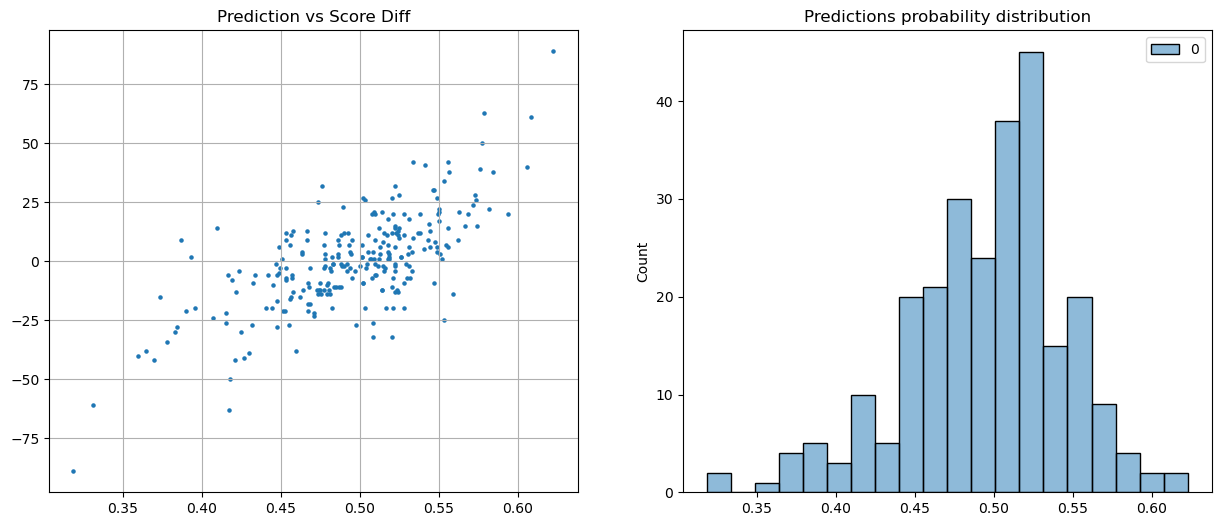

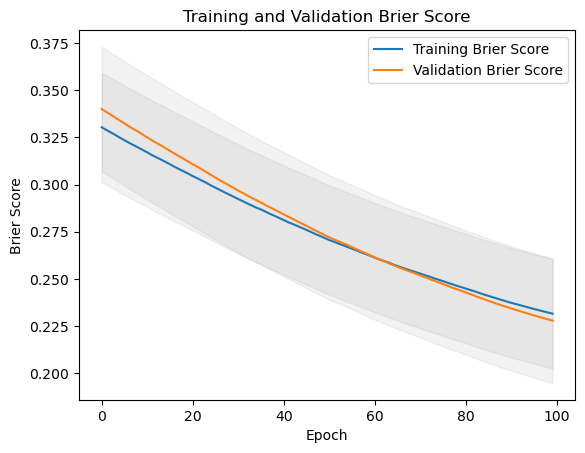

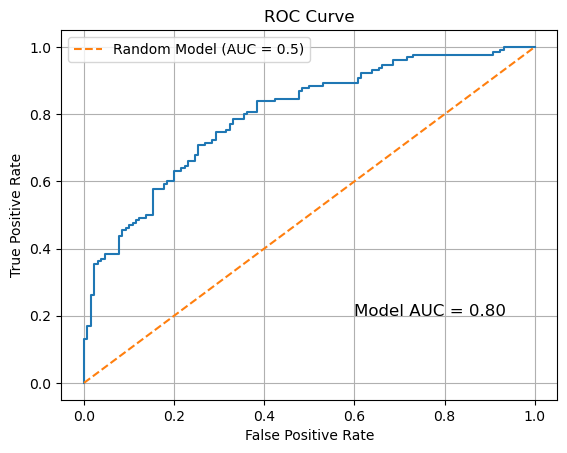

	 -> Scored 0.283

Validating on season 2018
4084/4084 [==============================] - 5s 1ms/step


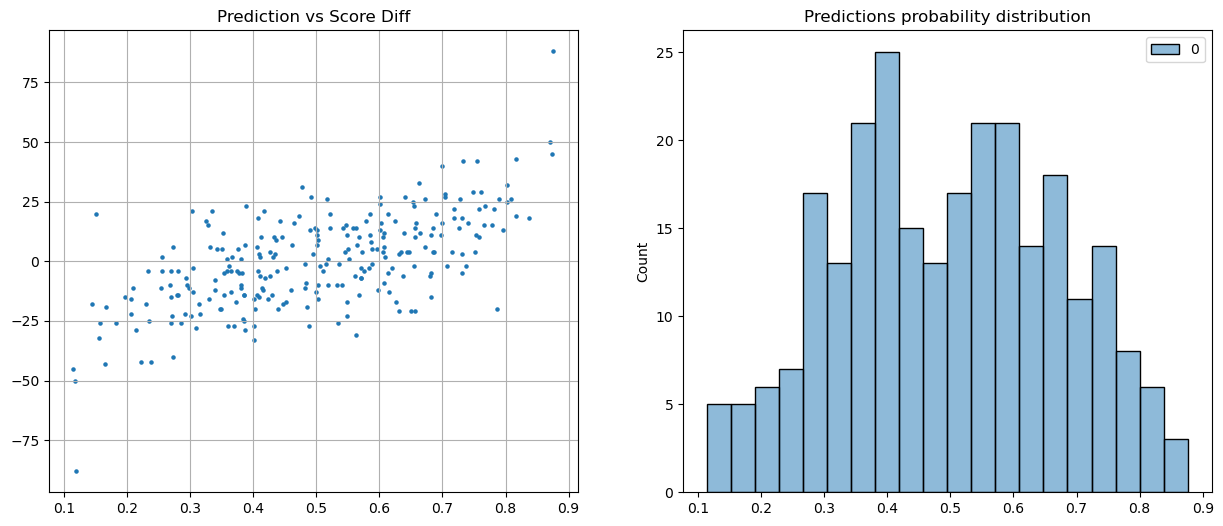

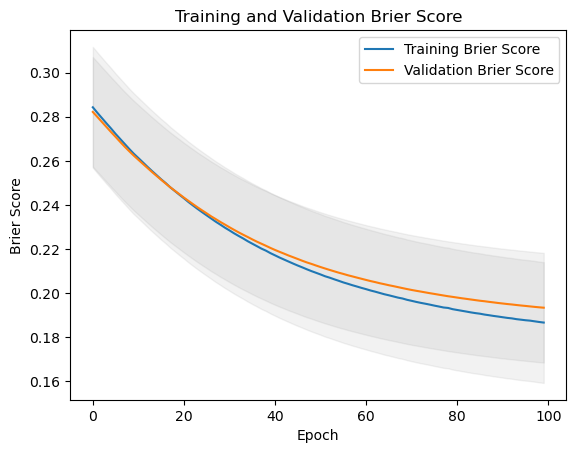

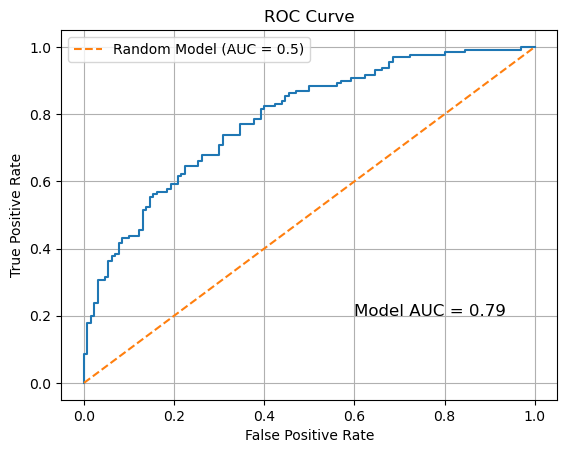

	 -> Scored 0.303

Validating on season 2019
4084/4084 [==============================] - 5s 1ms/step


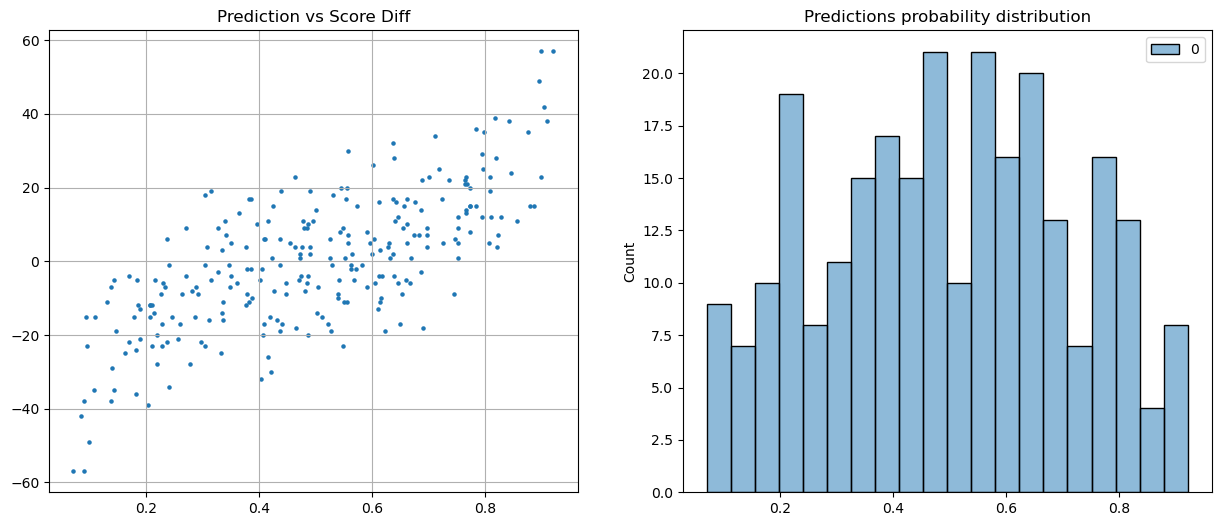

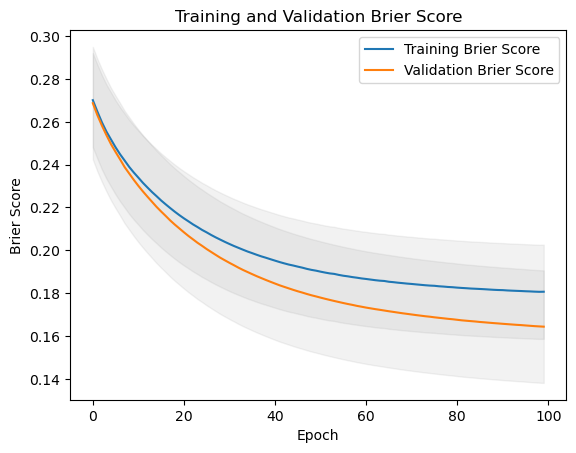

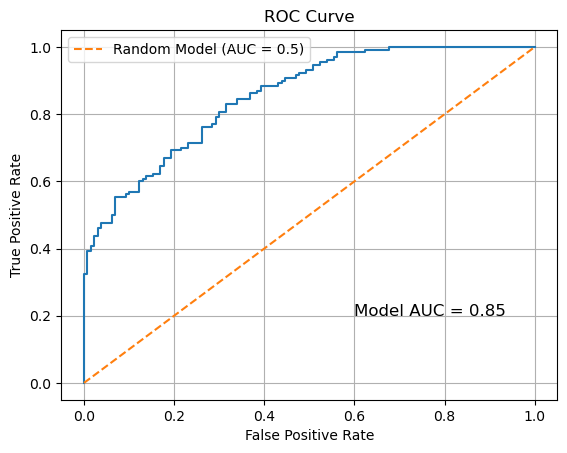

	 -> Scored 0.314

Validating on season 2021
4084/4084 [==============================] - 5s 1ms/step


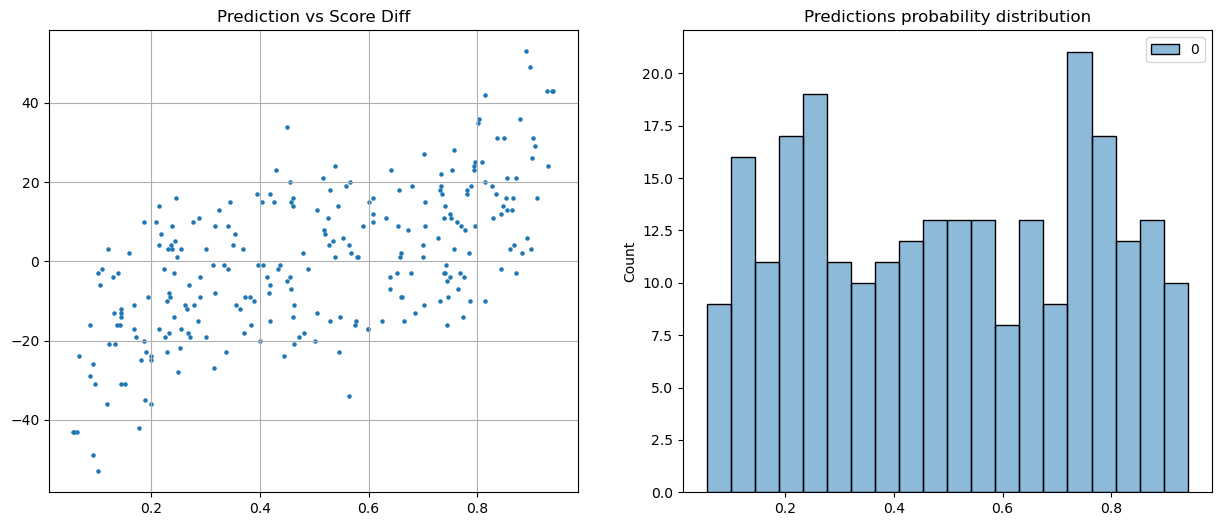

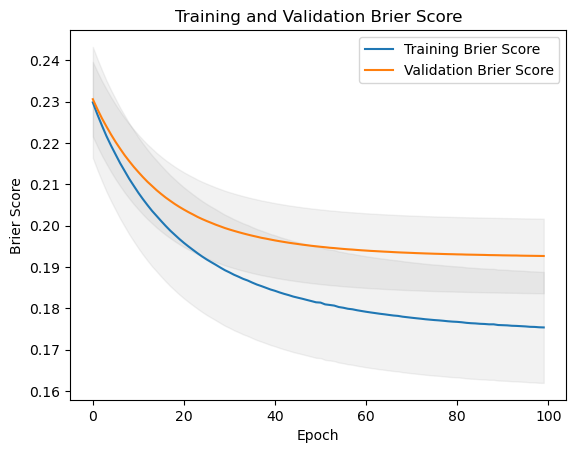

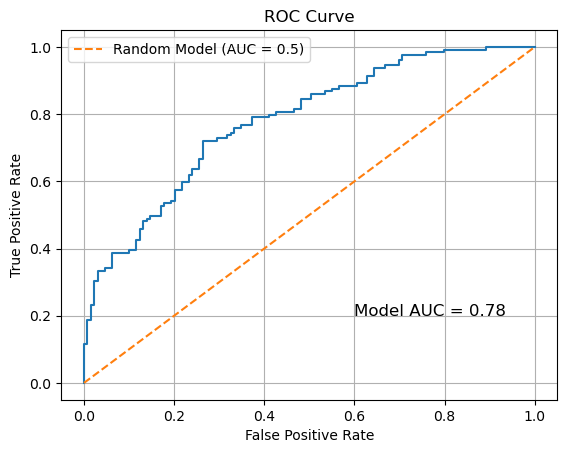

	 -> Scored 0.333

Validating on season 2022
4084/4084 [==============================] - 5s 1ms/step


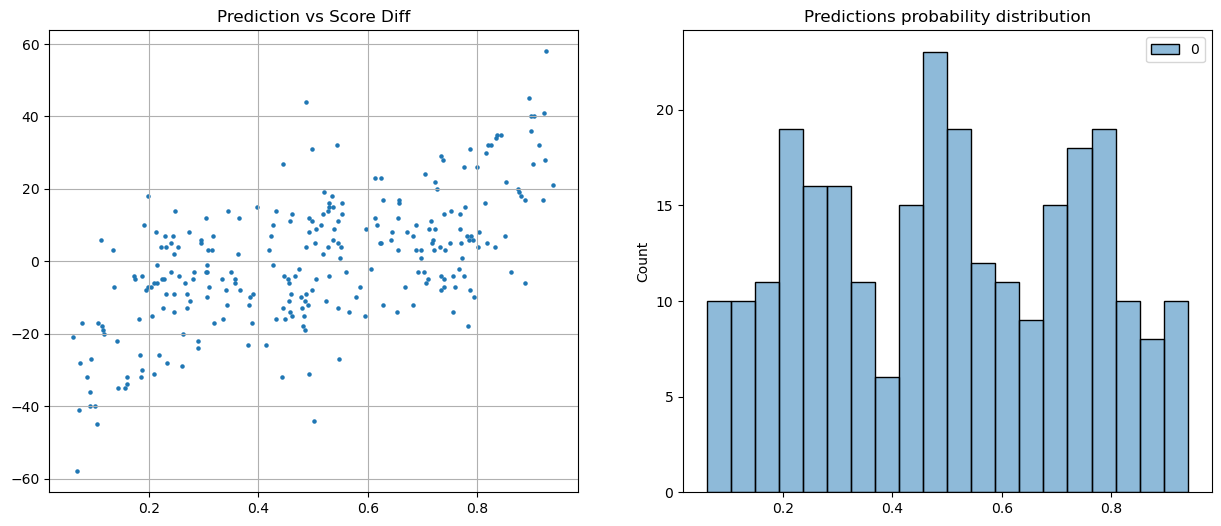

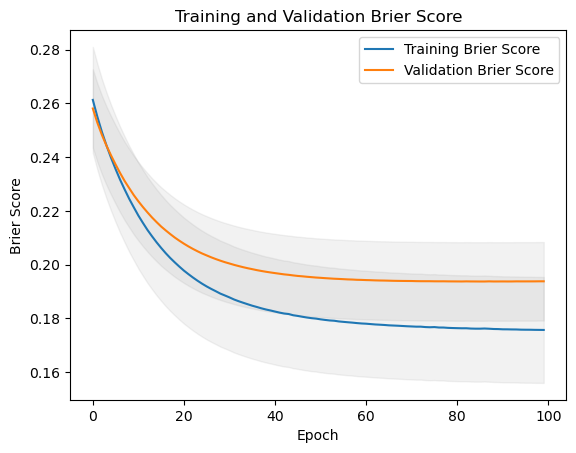

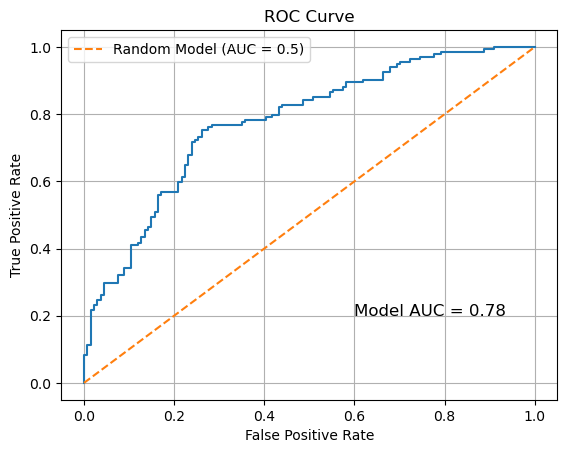

	 -> Scored 0.324

 Local CV is 0.312


In [47]:
pred_tests = kfold(df, df_test, plot=True, verbose=1, mode="cls")

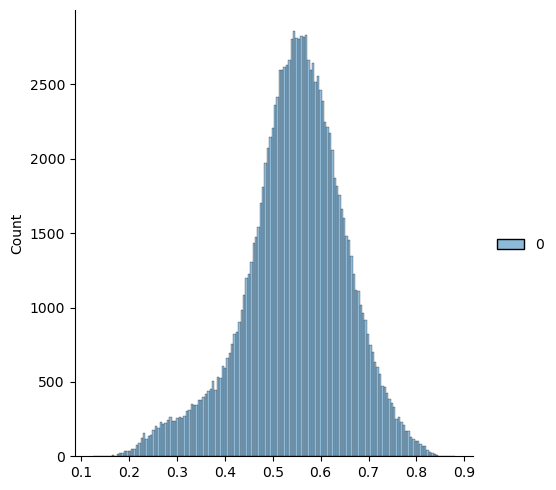

In [48]:
pred_test = np.mean(pred_tests, 0)
df_test['pred'] = pred_test

_ = sns.displot(pred_test)

In [49]:
final_sub = df_test[['ID', 'pred']].copy()
final_sub.to_csv('submission.csv', index=False)

In [50]:
final_sub.head(20)

,ID,pred
0,2023_1101_1102,0.543175
1,2023_1101_1103,0.474341
2,2023_1101_1104,0.398148
3,2023_1101_1105,0.565633
4,2023_1101_1106,0.630635
5,2023_1101_1107,0.633863
6,2023_1101_1108,0.530864
7,2023_1101_1110,0.528859
8,2023_1101_1111,0.543409
9,2023_1101_1112,0.434484
